In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sbi.inference import (
    likelihood_estimator_based_potential,
    SNPE,
    prepare_for_sbi,
    simulate_for_sbi,
    VIPosterior,
)
from sbi import utils as utils
from sbi import analysis as analysis

_ = torch.manual_seed(0)

In [13]:
num_dim = 2
prior = utils.BoxUniform(low=[4.2,0.005], high=[5.8,0.025])

In [14]:
def generate_ar1_time_series(theta):
    time_series = np.zeros(length)
    time_series[0] = x_0
    for t in range(1, length):
        noise = np.random.normal(0, theta[1])
        time_series[t] =  theta[0] * time_series[t - 1]**2 * (1-time_series[t - 1]) + noise
    return time_series

In [15]:
length = 200
x_0 = 0.25
simulator, prior = prepare_for_sbi(generate_ar1_time_series, prior)

In [9]:
c = 5.3
noise_std = 0.015

x_o = generate_ar1_time_series([c, noise_std])

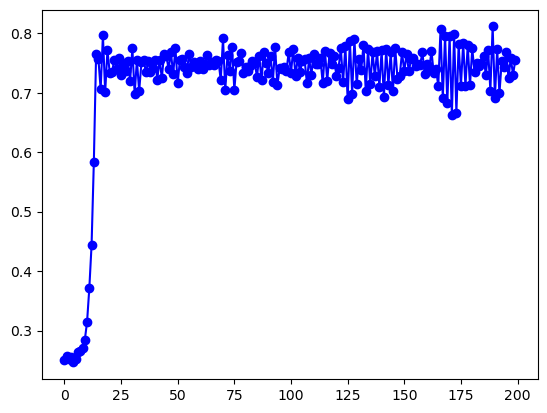

In [16]:
plt.plot(x_o, label='Time Series Data', color='blue', marker='o', linestyle='-')

In [18]:
class SummaryNet(nn.Module):
    
    def __init__(self,
                 in_channels = (1, 8, 16),
                 out_channels = (8, 16, 32),
                 kernel_sizes =  (5, 2, 5), 
                 padding = (0,0,0),
                 encoded_space_dim = 3, 
                 drop_p = 0.5,
                 act = nn.LeakyReLU,
                 seq_length = 200,
                 linear = 10,
                ):
        """
        Convolutional Network with three convolutional and two dense layers
        Args:
            in_channels : inputs channels
            out_channels : output channels
            kernel_sizes : kernel sizes
            padding : padding added to edges
            encoded_space_dim : dimension of encoded space
            drop_p : dropout probability
            act : activation function
            seq_len : length of input sequences 
            weight_decay : l2 regularization constant
            linea : linear layer units
        """
        super().__init__()
    
        # Retrieve parameters
        self.in_channels = in_channels #tuple of int, input channels for convolutional layers
        self.out_channels = out_channels #tuple of int, of output channels 
        self.kernel_sizes = kernel_sizes #tuple of tuples of int kernel size, single integer or tuple itself
        self.padding = padding
        self.encoded_space_dim = encoded_space_dim
        self.drop_p = drop_p
        self.act = act
        self.seq_length = seq_length
        self.linear = linear 
        self.pool_division = 4
 
      
        ### Network architecture
        # First convolutional layer (2d convolutional layer
        self.first_conv = nn.Sequential(
            nn.Conv1d(self.in_channels[0], self.out_channels[0], self.kernel_sizes[0], padding=self.padding[0]), 
            #nn.BatchNorm1d(self.out_channels[0]),
            self.act(inplace = True),
            nn.Dropout(self.drop_p, inplace = False),
            nn.AvgPool1d(self.pool_division)
        )
        
        # Second convolution layer
        self.second_conv = nn.Sequential(
            nn.Conv1d(self.in_channels[1], self.out_channels[1], self.kernel_sizes[1], padding=self.padding[1]), 
            #nn.BatchNorm1d(self.out_channels[1]),
            self.act(inplace = True),
            nn.Dropout(self.drop_p, inplace = False),
            nn.AvgPool1d(self.pool_division)
        )
        
        # Third convolutional layer
        self.third_conv = nn.Sequential(
            nn.Conv1d(self.in_channels[2], self.out_channels[2], self.kernel_sizes[2], padding=self.padding[2]), 
            #nn.BatchNorm1d(self.out_channels[2]),
            self.act(inplace = True),
            nn.Dropout(self.drop_p, inplace = False),
            nn.AvgPool1d(self.pool_division)
        )


        # Flatten layer
        self.flatten = nn.Flatten(start_dim=-2)
        
        # Liner dimension after 2 convolutional layers
        self.lin_dim = int((((self.seq_length-self.kernel_sizes[0]+1)/self.pool_division+1-self.kernel_sizes[1])/self.pool_division+1-self.kernel_sizes[2])/self.pool_division)
        
        # linear encoder
        self.encoder_lin= nn.Sequential(
                # First linear layer
                nn.Linear(self.out_channels[2]*self.lin_dim, self.linear),
                #nn.BatchNorm1d(self.linear),
                self.act(inplace = True),
                nn.Dropout(self.drop_p, inplace = False),
                # Second linear layer
                nn.Linear(self.linear, self.encoded_space_dim)
            )
        # # normalizing latent space layer
        #self.normalize_enc = nn.BatchNorm1d(self.encoded_space_dim)



    def forward(self, x):
        x =x.view(-1,1,200)
        x = self.first_conv(x)
        x = self.second_conv(x)
        x = self.third_conv(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x.view(-1,3)
        #return x.squeeze()
    
embedding_net = SummaryNet()


In [21]:
# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(
    model="maf", embedding_net=embedding_net, hidden_features=10, num_transforms=2
)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(prior=prior, density_estimator=neural_posterior)

In [12]:
num_rounds = 3

posteriors = []
proposal = prior

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=2000)
    likelihood_estimator = inference.append_simulations(
        theta, x,
    ).train()
    potential_fn, theta_transform = likelihood_estimator_based_potential(
        likelihood_estimator, prior, x_o
    )

    posterior = VIPosterior(
        potential_fn, prior, "maf", theta_transform, vi_method="fKL",
    ).train()
    posteriors.append(posterior)
    proposal = posterior

Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 512 epochs.

  0%|          | 0/2000 [00:00<?, ?it/s]

Quality Score: -0.578 	 Good: Smaller than 0.5  Bad: Larger than 1.0 	         NOTE: Less sensitive to mode collapse.


Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 140 epochs.

  0%|          | 0/2000 [00:00<?, ?it/s]

Quality Score: -0.622 	 Good: Smaller than 0.5  Bad: Larger than 1.0 	         NOTE: Less sensitive to mode collapse.


Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

 Neural network successfully converged after 78 epochs.

  0%|          | 0/2000 [00:00<?, ?it/s]

Quality Score: -0.446 	 Good: Smaller than 0.5  Bad: Larger than 1.0 	         NOTE: Less sensitive to mode collapse.
